##### __Author:__ Bram Van de Sande

__Date:__ 6 MAR 2018

__Outline:__ Tutorial on how to run the full SCENIC pipeline using the python implementation (i.e. pyscenic).

For this notebook 3005 single cell transcriptomes taken from the mouse brain (somatosensory cortex and hippocampal regions) are used as an example.

> A. Zeisel, A. B. M͡oz-Manchado, S. Codeluppi, P. Lönnerberg, G. L. Manno, A. Juréus, S. Marques, H. Munguba, L. He, C. Betsholtz, C. Rolny, G. Castelo-Branco, J. Hjerling-Leffler, and S. Linnarsson, “Cell types in the mouse cortex and hippocampus revealed by single-cell RNA-seq,” Science, vol. 347, no. 6226, pp. 1138–1142, Mar. 2015.

In [1]:
import pandas as pd
import numpy as np
import os, glob

from arboretum.utils import load_tf_names
from arboretum.algo import grnboost2

from pyscenic.rnkdb import FeatherRankingDatabase as RankingDatabase, convert2feather
from pyscenic.utils import add_correlation, modules_from_genie3, save_to_yaml
from pyscenic.prune import prune2df, prune, df2regulomes
from pyscenic.aucell import create_rankings, enrichment

import seaborn as sns

In [2]:
DATA_FOLDER="/Users/bramvandesande/Projects/lcb/tmp"
RESOURCES_FOLDER="/Users/bramvandesande/Projects/lcb/resources"
DATABASE_FOLDER = "/Users/bramvandesande/Projects/lcb/databases/"

SQLITE_GLOB = os.path.join(DATABASE_FOLDER, "mm9-*.mc9nr.db")
FEATHER_GLOB = os.path.join(DATABASE_FOLDER, "mm9-*.mc9nr.feather")

MOTIF_ANNOTATIONS_FNAME = os.path.join(RESOURCES_FOLDER, "motifs-v9-nr.mgi-m0.001-o0.0.tbl")
MM_TFS_FNAME = os.path.join(RESOURCES_FOLDER, 'mm_tfs.txt')
SC_EXP_FNAME = os.path.join(RESOURCES_FOLDER, "GSE60361_C1-3005-Expression.txt")

NOMENCLATURE = "MGI"

ADJACENCIES_FNAME = os.path.join(DATA_FOLDER, "adjacencies.tsv")
MODULES_FNAME = os.path.join(DATA_FOLDER, "modules.yaml")
REGULOMES_FNAME = os.path.join(DATA_FOLDER, "regulomes.yaml")

# Preliminary work

### Load the expression matrix

The scRNA-Seq data is downloaded from GEO: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE60361 .

In [3]:
ex_matrix = pd.read_csv(SC_EXP_FNAME, sep='\t', header=0, index_col=0)

Remove duplicate genes.

In [4]:
ex_matrix = ex_matrix[~ex_matrix.index.duplicated(keep='first')]

In [5]:
ex_matrix.head()

,1772071015_C02,1772071017_G12,1772071017_A05,1772071014_B06,1772067065_H06,1772071017_E02,1772067065_B07,1772067060_B09,1772071014_E04,1772071015_D04,...,1772066110_D12,1772071017_A07,1772063071_G10,1772058148_C03,1772063061_D09,1772067059_B04,1772066097_D04,1772063068_D01,1772066098_A12,1772058148_F03
cell_id,,,,,,,,,,,,,,,,,,,,,
Tspan12,0,0,0,3,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Tshz1,3,1,0,2,2,2,2,1,0,2,...,0,0,0,0,0,0,0,0,0,1
Fnbp1l,3,1,6,4,1,2,1,0,5,2,...,0,0,0,0,0,0,0,0,0,0
Adamts15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cldn12,1,1,1,0,0,0,0,0,2,3,...,0,0,0,0,0,0,0,0,0,0


In [6]:
ex_matrix.shape

(19970, 3005)

_Caveat: Either the raw counts can be used, or a `log2(count+1)` transformation can be used._

### Derive list of Transcription Factors(TF) for _Mus musculus_

List of known TFs for Mm was prepared (cf. notebook).

In [7]:
tf_names = load_tf_names(MM_TFS_FNAME)

### Load ranking databases

Make databases in feather format are available.

In [8]:
if False:
    def derive_db_name(fname):
        return os.path.basename(fname).split(".")[0]

    from pyscenic.rnkdb import convert2feather
    
    for fname in glob.glob(SQLITE_GLOB):
        convert2feather(fname, DATABASE_FOLDER, derive_db_name(fname), NOMENCLATURE)

In [9]:
db_fnames = glob.glob(FEATHER_GLOB)
def name(fname):
    return os.path.basename(fname).split(".")[0]
dbs = [RankingDatabase(fname=fname, name=name(fname), nomenclature="MGI") for fname in db_fnames]

In [10]:
dbs

[FeatherRankingDatabase(name="mm9-tss-centered-10kb-10species",nomenclature=MGI),
 FeatherRankingDatabase(name="mm9-500bp-upstream-7species",nomenclature=MGI),
 FeatherRankingDatabase(name="mm9-500bp-upstream-10species",nomenclature=MGI),
 FeatherRankingDatabase(name="mm9-tss-centered-5kb-10species",nomenclature=MGI),
 FeatherRankingDatabase(name="mm9-tss-centered-10kb-7species",nomenclature=MGI),
 FeatherRankingDatabase(name="mm9-tss-centered-5kb-7species",nomenclature=MGI)]

# Phase I: Inference of co-expression modules

In the initial phase of the pySCENIC pipeline the single cell expression profiles are used to infer co-expression modules from.

### Run GRNboost from `arboretum` to infer co-expression modules

The arboretum package is used for this phase of the pipeline. For this notebook only a sample of 1,000 cells is used for the co-expression module inference is used.

In [11]:
N_SAMPLES = 500

In [12]:
adjancencies = grnboost2(expression_data=ex_matrix.T.sample(n=N_SAMPLES, replace=False),
                    tf_names=tf_names, verbose=True)

preparing dask client
parsing input
creating dask graph
computing dask graph
shutting down client and local cluster
finished


In [13]:
adjancencies.head()

,TF,target,importance
157,Tcf7l2,Nfasc,60.207182
172,Olig1,Mbp,60.016574
157,Tcf7l2,Itpr2,59.006877
35,Rpl7,Gm9846,58.076907
155,Neurod6,Hpca,58.076307


In [14]:
len(adjancencies)

3812952

In [15]:
adjancencies.to_csv(ADJACENCIES_FNAME, index=False, sep='\t')

### Derive potential regulomes from these co-expression modules

Relationship between TF and its target, i.e. activator or repressor, is derived using the original expression profiles. The Pearson product-moment correlation coefficient is used to derive this information.

In [16]:
adjacencies = add_correlation(adjancencies, ex_matrix)

The first method to create the TF-modules is to select the best targets for each transcription factor:
1. Targets with weight > 0.001
1. Targets with weight > 0.005

The second method is to select the top targets for a given TF:
1. Top 50 targets (targets with highest weight)

The alternative way to create the TF-modules is to select the best regulators for each gene (this is actually how GENIE3 internally works). Then, these targets can be assigned back to each TF to form the TF-modules. In this way we will create three more gene-sets:
1. Targets for which the TF is within its top 5 regulators
1. Targets for which the TF is within its top 10 regulators
1. Targets for which the TF is within its top 50 regulators

In [17]:
modules = list(modules_from_genie3(adjacencies[adjacencies['correlation'] > 0.0], NOMENCLATURE))

Add the transcription factor to the module.

In [18]:
def add_tf(module):
    return module.add(module.transcription_factor)
modules = list(map(add_tf, modules))

Remove modules that are less than 20 genes.

In [19]:
modules = list(filter(lambda m: len(m) >= 20, modules))

_Caveat: in the original SCENIC tutorial the genes that are not part of the whole genome ranking are removed from the signature. For pySCENIC this is not required._

In [20]:
save_to_yaml(modules, MODULES_FNAME)

# Phase II: Prune modules for targets with cis regulatory footprints (aka RcisTarget)

In [21]:
regulomes = prune(dbs, modules, MOTIF_ANNOTATIONS_FNAME)

Using 6 workers.
2018-03-06 13:51:09.199052 - Worker mm9-tss-centered-5kb-10species(1): database loaded in memory.
2018-03-06 13:51:11.150749 - Worker mm9-500bp-upstream-10species(1): database loaded in memory.
2018-03-06 13:51:12.064328 - Worker mm9-tss-centered-5kb-7species(1): database loaded in memory.
2018-03-06 13:51:12.065082 - Worker mm9-tss-centered-10kb-10species(1): database loaded in memory.
2018-03-06 13:51:12.065749 - Worker mm9-500bp-upstream-7species(1): database loaded in memory.
2018-03-06 13:51:12.099034 - Worker mm9-tss-centered-10kb-7species(1): database loaded in memory.
2018-03-06 13:51:12.590144 - Worker mm9-tss-centered-5kb-10species(1): motif annotations loaded in memory.
2018-03-06 13:51:13.349636 - Worker mm9-500bp-upstream-10species(1): motif annotations loaded in memory.
2018-03-06 13:51:13.973820 - Worker mm9-500bp-upstream-7species(1): motif annotations loaded in memory.
2018-03-06 13:51:13.993361 - Worker mm9-tss-centered-5kb-7species(1): motif annotati

_Caveat: Inspection of the results is possible via the creation of a dataframe instead of a list of regulomes._

In [22]:
df = prune2df(dbs, modules, MOTIF_ANNOTATIONS_FNAME)

Using 6 workers.
2018-03-06 14:25:45.690521 - Worker mm9-tss-centered-5kb-7species(1): database loaded in memory.
2018-03-06 14:25:46.702356 - Worker mm9-tss-centered-10kb-10species(1): database loaded in memory.
2018-03-06 14:25:46.712435 - Worker mm9-500bp-upstream-7species(1): database loaded in memory.
2018-03-06 14:25:46.710807 - Worker mm9-tss-centered-10kb-7species(1): database loaded in memory.
2018-03-06 14:25:46.794726 - Worker mm9-tss-centered-5kb-10species(1): database loaded in memory.
2018-03-06 14:25:46.948488 - Worker mm9-500bp-upstream-10species(1): database loaded in memory.
2018-03-06 14:25:48.571641 - Worker mm9-tss-centered-5kb-7species(1): motif annotations loaded in memory.
2018-03-06 14:25:48.882867 - Worker mm9-tss-centered-10kb-10species(1): motif annotations loaded in memory.
2018-03-06 14:25:48.887396 - Worker mm9-tss-centered-10kb-7species(1): motif annotations loaded in memory.
2018-03-06 14:25:48.905718 - Worker mm9-500bp-upstream-7species(1): motif annot

In [23]:
regulomes = df2regulomes(df, "HGNC")

This dataframe can then be converted to regulomes.

In [24]:
save_to_yaml(regulomes, REGULOMES_FNAME)

# Phase III: Cellular regulome enrichment matrix (aka AUCell)

Characterize the different cells in a single-cell transcriptomics experiment by the enrichment of the regulomes. Enrichment of a regulome is measures as AUC of the recovery curve of the genes that define this regulome.

In [54]:
rnk_mtx = create_rankings(ex_matrix.T)

In [59]:
auc_mtx = pd.concat([enrichment(rnk_mtx, regulome, rank_threshold=1500) for regulome in regulomes]).unstack("Regulome")

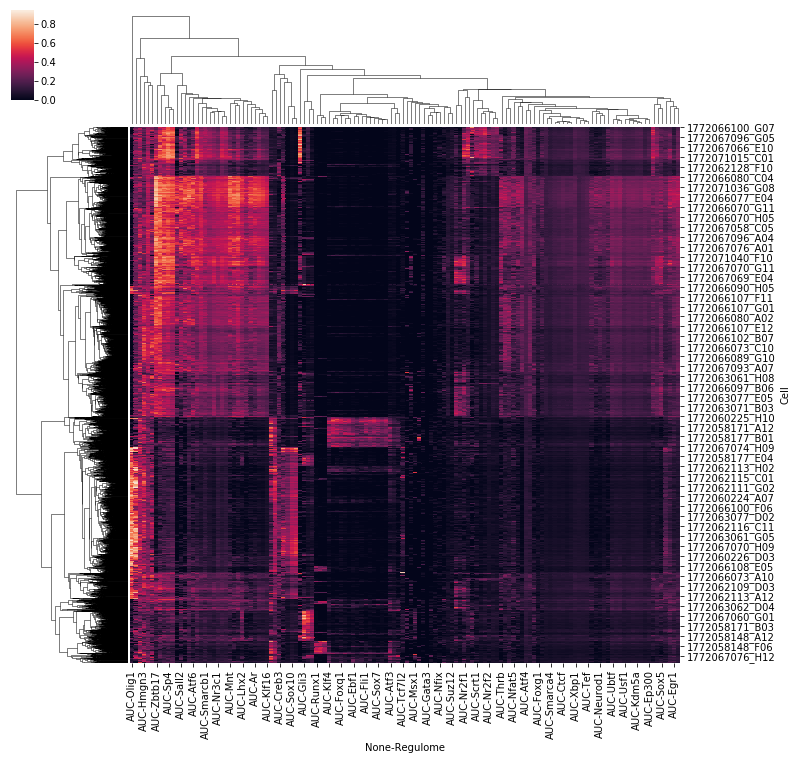

In [60]:
sns.clustermap(auc_mtx, figsize=(12,12))